In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import r2_score

chosed_dataset = 'BPI_Challenge_2017'

In [15]:
df = pd.read_csv(f'../data/clean_{chosed_dataset}.csv')

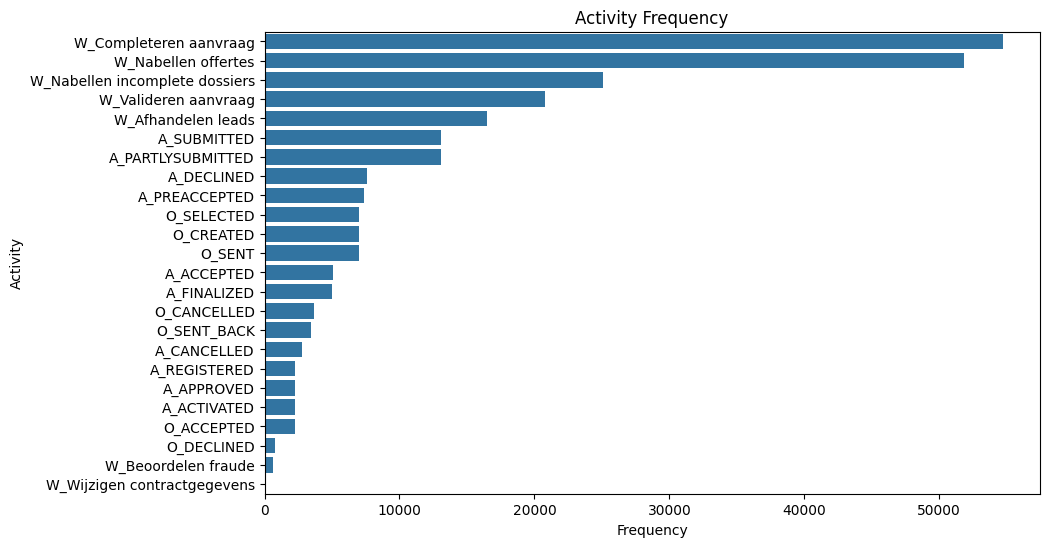

In [16]:
activity_counts = df['concept:name'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=activity_counts.values, y=activity_counts.index)
plt.xlabel('Frequency')
plt.ylabel('Activity')
plt.title('Activity Frequency')
plt.show()

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_81216/465484979.py:3: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  case_durations = df.groupby('case:concept:name')['time:timestamp'].agg([min, max])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_81216/465484979.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  case_durations = df.groupby('case:concept:name')['time:timestamp'].agg([min, max])


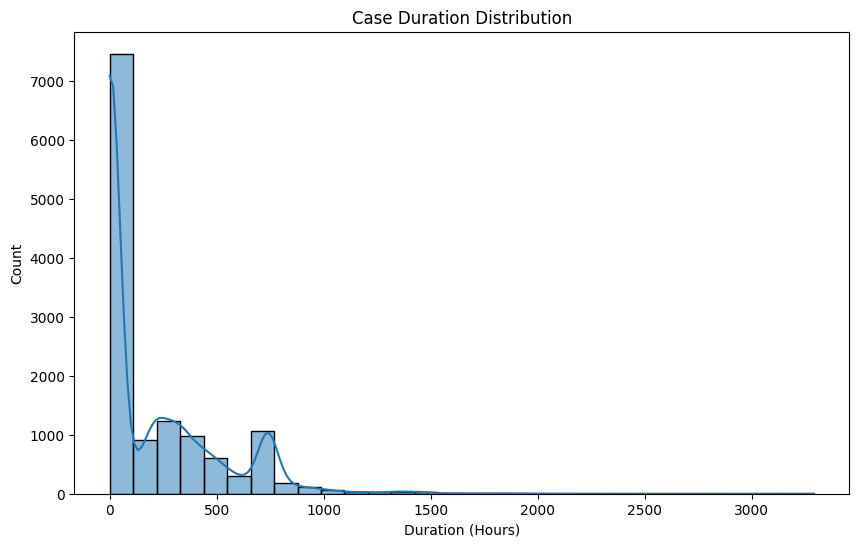

In [17]:
# Assuming 'time:timestamp' is the timestamp and 'case:concept:name' is the case ID
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])
case_durations = df.groupby('case:concept:name')['time:timestamp'].agg([min, max])
case_durations['duration'] = (case_durations['max'] - case_durations['min']).dt.total_seconds() / 3600  # Duration in hours

plt.figure(figsize=(10, 6))
sns.histplot(case_durations['duration'], bins=30, kde=True)
plt.xlabel('Duration (Hours)')
plt.ylabel('Count')
plt.title('Case Duration Distribution')
plt.show()


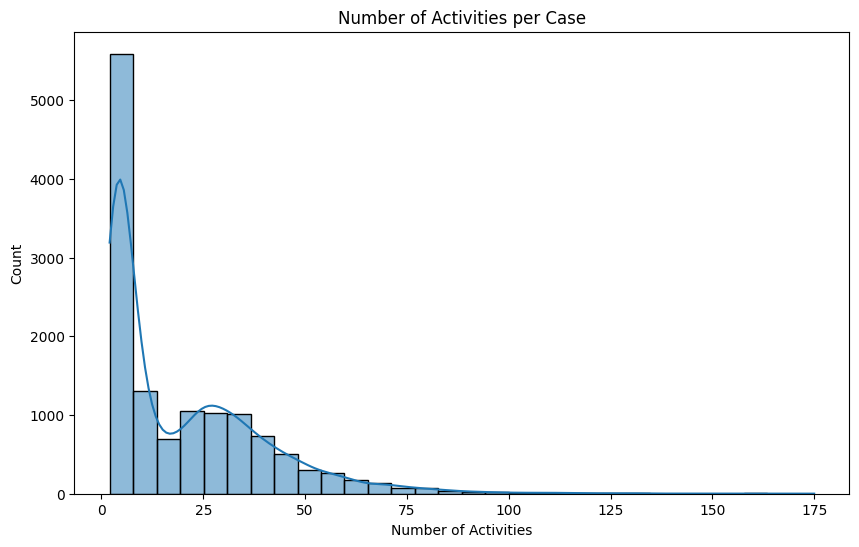

In [18]:
activities_per_case = df.groupby('case:concept:name').size()

plt.figure(figsize=(10, 6))
sns.histplot(activities_per_case, bins=30, kde=True)
plt.xlabel('Number of Activities')
plt.ylabel('Count')
plt.title('Number of Activities per Case')
plt.show()


Text(0, 0.5, 'Frequency')

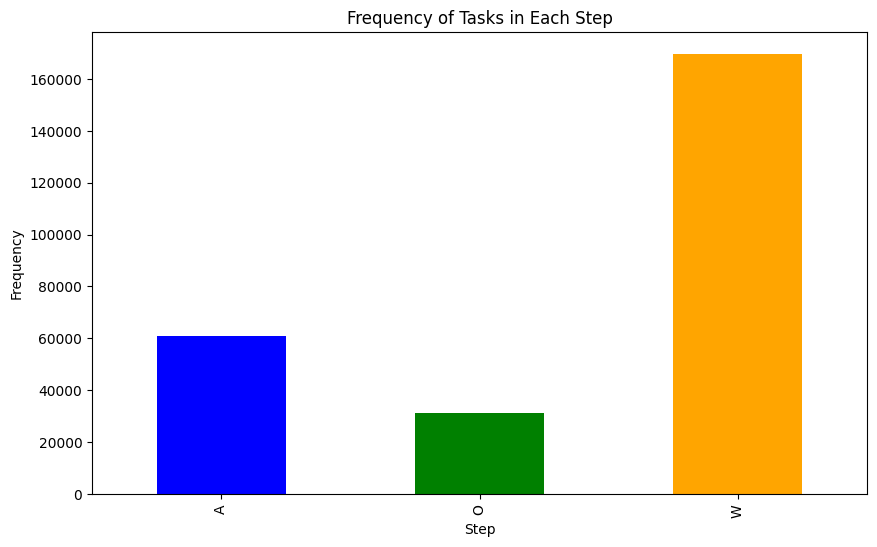

In [19]:
# Extract prefixes ('W_', 'O_', 'A_')
df['prefix'] = df['concept:name'].str.split('_').str[0]

# Create separate columns for each step
df['W'] = df['prefix'].apply(lambda x: x == 'W')
df['O'] = df['prefix'].apply(lambda x: x == 'O')
df['A'] = df['prefix'].apply(lambda x: x == 'A')

# Plot the frequency of tasks chosen at each step
fig, ax = plt.subplots(figsize=(10, 6))

df.groupby('prefix').size().plot(kind='bar', color=['blue', 'green', 'orange'], ax=ax)
ax.set_title('Frequency of Tasks in Each Step')
ax.set_xlabel('Step')
ax.set_ylabel('Frequency')

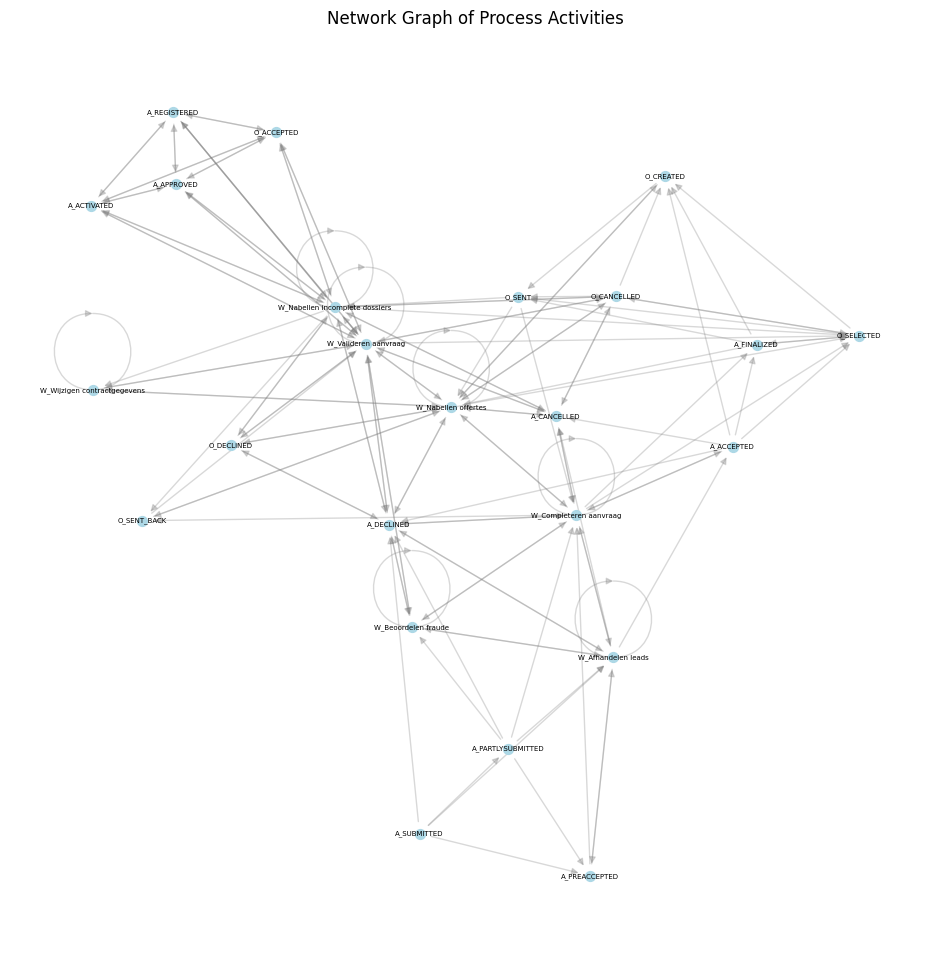

In [20]:
# Create a directed graph
G = nx.DiGraph()

# Add edges for transitions between activities for each case
# Here, we'll track the last activity to create a sequence within each case
last_activity = {}

for index, row in df.iterrows():
    case_id = row['case:concept:name']
    activity = row['concept:name']
    
    # Check if the current case had a previous activity
    if case_id in last_activity:
        # Add edge from last activity to current activity for the same case
        G.add_edge(last_activity[case_id], activity)
    
    # Update the last activity for the current case
    last_activity[case_id] = activity

# Use a spring layout to visualize the graph, attempting to reflect some hierarchy or sequence
pos = nx.spring_layout(G, seed=42)  # Seed for reproducible layout

# Drawing the graph
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="lightblue")
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=5, font_family="sans-serif")

plt.title("Network Graph of Process Activities")
plt.axis("off")  # Turn off the axis
plt.show()

# Creation of Naive Model

In [21]:
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])

# Generate event sequence numbers within each case
df['event_seq'] = df.groupby('case:concept:name').cumcount() + 1

# Calculate the difference between the current event's timestamp and the next one
df['time_to_next_event'] = df.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.diff().shift(-1))

# Convert the 'time_to_next_event' from timedelta to seconds (or any other numeric representation you prefer)
df['time_to_next_event_seconds'] = df['time_to_next_event'].dt.total_seconds().fillna(0)

# Step 2: Compute the mean duration for each 'concept:name'
average_durations_per_concept = df[['time_to_next_event_seconds', 'concept:name']].groupby('concept:name').median().rename(columns={'time_to_next_event_seconds': 'mean_duration_seconds'})

# Step 3: Merge this mean duration back into the original dataframe to use as a prediction
df = pd.merge(df, average_durations_per_concept, how='left', on='concept:name')

# Rename the 'mean_duration_seconds' column to something like 'predicted_duration_seconds'
df.rename(columns={'mean_duration_seconds': 'predicted_time_to_next_event_seconds'}, inplace=True)

df[['predicted_time_to_next_event_seconds', 'time_to_next_event_seconds']] = df[['predicted_time_to_next_event_seconds', 'time_to_next_event_seconds']].round(2)

# Optionally, convert the 'predicted_time_to_next_event_seconds' back to a timedelta for readability or further datetime operations
# dataframe_2012['predicted_time_to_next_event'] = pd.to_timedelta(dataframe_2012['predicted_time_to_next_event_seconds'], unit='s')

df

,Unnamed: 0,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,start_timestamp,timestamp_difference,prefix,W,O,A,event_seq,time_to_next_event,time_to_next_event_seconds,predicted_time_to_next_event_seconds
0,0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546,01:10:2011 00:38:44.546000,173688,20000,2011-10-01 00:38:44.546000+00:00,NaN,A,False,False,True,1,0 days 00:00:00.334000,0.33,0.27
1,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880,01:10:2011 00:38:44.546000,173688,20000,2011-10-01 00:38:44.880000+00:00,0 days 00:00:00.334000,A,False,False,True,2,0 days 00:00:53.026000,53.03,37.00
2,2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906,01:10:2011 00:38:44.546000,173688,20000,2011-10-01 00:39:37.906000+00:00,0 days 00:00:53.026000,A,False,False,True,3,0 days 00:00:00.969000,0.97,0.38
3,3,112.0,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875,01:10:2011 00:38:44.546000,173688,20000,2011-10-01 00:39:38.875000+00:00,0 days 00:00:00.969000,W,True,False,False,4,0 days 10:57:07.562000,39427.56,317.15
4,26,112.0,COMPLETE,A_SUBMITTED,2011-10-01 08:08:58.256,01:10:2011 08:08:58.256000,173691,5000,2011-10-01 08:08:58.256000+00:00,NaN,A,False,False,True,1,0 days 00:00:03.939000,3.94,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261441,256158,10863.0,START,W_Nabellen incomplete dossiers,2012-03-14 15:59:28.309,27:02:2012 14:12:41.868000,213276,15000,2012-03-14 15:59:28.309000+00:00,0 days 00:22:26.421000,W,True,False,False,36,0 days 00:00:41.371000,41.37,324.40
261442,256159,10863.0,COMPLETE,W_Nabellen incomplete dossiers,2012-03-14 16:00:09.680,27:02:2012 14:12:41.868000,213276,15000,2012-03-14 16:00:09.680000+00:00,0 days 00:00:41.371000,W,True,False,False,37,NaT,0.00,324.40
261443,235011,11169.0,START,W_Nabellen offertes,2012-03-14 16:02:03.883,15:02:2012 10:10:36.503000,209595,13000,2012-03-14 16:02:03.883000+00:00,5 days 19:12:30.382000,W,True,False,False,33,NaT,0.00,158.02
261444,246922,11203.0,START,W_Nabellen incomplete dossiers,2012-03-14 16:04:46.192,21:02:2012 23:38:40.044000,211624,35000,2012-03-14 16:04:46.192000+00:00,0 days 00:08:38.193000,W,True,False,False,35,0 days 00:00:08.489000,8.49,324.40


In [22]:
df = df.drop(columns=['column_similarity_percentage'], errors='ignore')

# Subtract the timestamp of the first event in each case from all events in that case
df['elapsed_time_from_start'] = df.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x - x.min())

# Calculate the average elapsed time from the start for each 'event_seq'
predicted_start_time = df.groupby('event_seq')['elapsed_time_from_start'].mean().reset_index(name='predicted_start_time')

# Merge this average elapsed time back into the original DataFrame to use as a predicted start time
df = pd.merge(df, predicted_start_time, on='event_seq', how='left')

In [23]:
# Step 1: Shift the 'concept:name' within each group to get the next step
# dataframe_2012['next_step'] = dataframe_2012.groupby('case:concept:name')['concept:name'].shift(-1)

# Step 2: For each 'concept:name', calculate the most common next step
# We'll group by 'concept:name' and then use value_counts on 'next_step' to find the most common follow-up step
#most_common_next_steps = dataframe_2012.groupby('concept:name')['next_step'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(n

# Merge the most common next step back into the original DataFrame
#dataframe_2012 = pd.merge(dataframe_2012, most_common_next_steps, how='left', on='concept:name')

# Rename the merged column to 'predicted_next_step'
#dataframe_2012.rename(columns={'most_common_next_step': 'predicted_next_step'}, inplace=True)

In [24]:
# Calculate the most common concept:name for each event_seq
most_common_concepts_by_seq = df.groupby('event_seq')['concept:name'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(name='predicted_step')

# Merge the most common concept:name for each event_seq back into the original DataFrame
df = pd.merge(df, most_common_concepts_by_seq, on='event_seq', how='left')

In [25]:
df['column_similarity_percentage'] = (df['concept:name'] == df['predicted_step']).mean() * 100

# accuracy for label prediction
accuracy = df['column_similarity_percentage'].loc[0]

# r2 for time prediction
r2_time = r2_score(df['time_to_next_event_seconds'], df['predicted_time_to_next_event_seconds'])

# rename columns with predictions
df = df.rename(columns={'predicted_step': 'next concept:name naive', 'predicted_time_to_next_event_seconds': 'next time:timestamp naive', 'time_to_next_event': 'next time:timestamp', 'timestamp_difference': 'time:timestamp diff'}, errors='ignore')

# convert the times back to timestamps
df['next time:timestamp'] = df['time:timestamp'] + df['next time:timestamp']
df['next time:timestamp naive'] = pd.to_timedelta(df['next time:timestamp naive'], unit='s')
df['next time:timestamp naive'] = df['time:timestamp'] + df['next time:timestamp naive']
df['next concept:name naive'] = df.groupby('case:concept:name')['next concept:name naive'].shift(-1)

# drop columns that are not going to be used
df = df.drop(columns=['column_similarity_percentage', 'predicted_start_time', 'elapsed_time_from_start', 'time_to_next_event_seconds', 'event_seq', 'A', 'O', 'W', 'prefix'], errors='ignore')

# save to the csv 
df.to_csv(f"../data/{chosed_dataset}_naive.csv")

print(f"""
    Metrics for Baseline model (Naive Model):\n
    Accuracy for next event prediction: {accuracy}% \n
    R\u00B2 of time prediction for next event: {r2_time}
""")


    Metrics for Baseline model (Naive Model):

    Accuracy for next event prediction: 48.13651767477797% 

    R² of time prediction for next event: -0.06409879676392682



In [26]:
df

,Unnamed: 0,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,start_timestamp,time:timestamp diff,next time:timestamp,next time:timestamp naive,next concept:name naive
0,0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546,01:10:2011 00:38:44.546000,173688,20000,2011-10-01 00:38:44.546000+00:00,NaN,2011-10-01 00:38:44.880,2011-10-01 00:38:44.816,A_PARTLYSUBMITTED
1,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880,01:10:2011 00:38:44.546000,173688,20000,2011-10-01 00:38:44.880000+00:00,0 days 00:00:00.334000,2011-10-01 00:39:37.906,2011-10-01 00:39:21.880,A_PREACCEPTED
2,2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906,01:10:2011 00:38:44.546000,173688,20000,2011-10-01 00:39:37.906000+00:00,0 days 00:00:53.026000,2011-10-01 00:39:38.875,2011-10-01 00:39:38.286,W_Completeren aanvraag
3,3,112.0,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875,01:10:2011 00:38:44.546000,173688,20000,2011-10-01 00:39:38.875000+00:00,0 days 00:00:00.969000,2011-10-01 11:36:46.437,2011-10-01 00:44:56.025,W_Completeren aanvraag
4,26,112.0,COMPLETE,A_SUBMITTED,2011-10-01 08:08:58.256,01:10:2011 08:08:58.256000,173691,5000,2011-10-01 08:08:58.256000+00:00,NaN,2011-10-01 08:09:02.195,2011-10-01 08:08:58.526,A_PARTLYSUBMITTED
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261441,256158,10863.0,START,W_Nabellen incomplete dossiers,2012-03-14 15:59:28.309,27:02:2012 14:12:41.868000,213276,15000,2012-03-14 15:59:28.309000+00:00,0 days 00:22:26.421000,2012-03-14 16:00:09.680,2012-03-14 16:04:52.709,W_Nabellen offertes
261442,256159,10863.0,COMPLETE,W_Nabellen incomplete dossiers,2012-03-14 16:00:09.680,27:02:2012 14:12:41.868000,213276,15000,2012-03-14 16:00:09.680000+00:00,0 days 00:00:41.371000,NaT,2012-03-14 16:05:34.080,NaN
261443,235011,11169.0,START,W_Nabellen offertes,2012-03-14 16:02:03.883,15:02:2012 10:10:36.503000,209595,13000,2012-03-14 16:02:03.883000+00:00,5 days 19:12:30.382000,NaT,2012-03-14 16:04:41.903,NaN
261444,246922,11203.0,START,W_Nabellen incomplete dossiers,2012-03-14 16:04:46.192,21:02:2012 23:38:40.044000,211624,35000,2012-03-14 16:04:46.192000+00:00,0 days 00:08:38.193000,2012-03-14 16:04:54.681,2012-03-14 16:10:10.592,W_Nabellen offertes
